In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as cp
import sys
sys.path.append("../../utils")
import os
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array, median_results_array
from plotting_performance_vs_metric import get_rff_memory_with_model, get_nystrom_memory_with_model
from plotting_performance_vs_metric import get_cir_rff_memory_with_model, get_cir_rff_memory_with_lm_halp_model
from plotting_performance_vs_metric import save_csv_with_error_bar

# from plotting_performance_vs_metric import get_rff_memory, get_nystrom_memory, get_cir_rff_memory
import math
from copy import deepcopy
import numpy as np
from plotting_performance_vs_metric import get_results_for_one_precision, plot_figure
from plot_utils import get_colors

### the data folder is called full tuning run but it is the full run after tuning round

In [2]:
def get_performance_list(n_feat_list, general_folder, folder_pattern, seeds, min_metric_best, performance_file_name, do_median, y_reverse=False):
        metric_list_all = []
        for seed in seeds:
            metric_list = []
            for n_feat in n_feat_list:
                subfolder = deepcopy(folder_pattern)
#                 subfolder = subfolder.replace("type_unk", "type_rff")
                subfolder = subfolder.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
                subfolder = subfolder.replace("seed_unk", "seed_" + str(seed) )
                folder_name = general_folder + "/" + subfolder
                file_name = performance_file_name
                metric = get_performance_metric(folder_name, file_name, min_best=min_metric_best)
                metric_list.append(metric)
            metric_list_all.append(np.array(deepcopy(metric_list) ) )            
            if y_reverse:
                metric_list_all[-1] = 1.0 - metric_list_all[-1]
        return metric_list_all

In [3]:
def get_metric_list(n_feat_list, general_folder, folder_pattern, seeds, min_metric_best, metric_file_name, metric_name, do_median):
        metric_list_all = []
        for seed in seeds:
            metric_list = []
            for n_feat in n_feat_list:
                subfolder = deepcopy(folder_pattern)
#                 subfolder = subfolder.replace("type_unk", "type_rff")
                subfolder = subfolder.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
                subfolder = subfolder.replace("seed_unk", "seed_" + str(seed) )
                folder_name = general_folder + "/" + subfolder
                file_name = metric_file_name
                metric = get_measurement_metric(folder_name, file_name, metric_name)
                metric_list.append(metric)
            metric_list_all.append(np.array(deepcopy(metric_list) ) )
        return metric_list_all

In [4]:
# def get_mem_saving(baseline_perf, baseline_mem, lp_perf, lp_mem, threshold=0.001, min_best=True):
#     lp_mem_saving = []
#     for key in lp_perf.keys():
#         if min_best:
#             idx = np.argmax(lp_perf[key] <= baseline_perf * (1.0 + threshold) )
#             if np.sum(lp_perf[key] <= baseline_perf * (1.0 + threshold) ) == 0:
#                 idx = -1
#         else:
#             idx = np.argmax(lp_perf[key] >= baseline_perf * (1.0 - threshold) )
#             if np.sum(lp_perf[key] >= baseline_perf * (1.0 - threshold) ) == 0:
#                 idx = -1
#         print "baseline / lp ", idx, baseline_mem, lp_mem[key][idx], baseline_perf, lp_perf[key][idx]
#         if idx == -1:
#             lp_mem_saving.append(-1)
#         else:
#             lp_mem_saving.append(baseline_mem /float(lp_mem[key][idx] ) )
#     print "lp memory saving ", np.max(lp_mem_saving)
#     return np.max(lp_mem_saving)

def get_mem_saving(baseline_perf_list, baseline_mem_list, lp_perf_list, lp_mem_list, threshold=0.001, min_best=True, use_median_ref=False):
        lp_mem_saving = []
        if use_median_ref:            
            baseline_perf = np.sort(baseline_perf_list)[len(baseline_perf_list)//2]
            print "median", baseline_perf
        elif min_best:            
            baseline_perf = np.min(baseline_perf_list) 
            print " min ", baseline_perf
        else:            
            baseline_perf = np.max(baseline_perf_list) 
            print " max ", baseline_perf
                        
        for key in lp_perf_list.keys():            
            lp_perf_list[key] = average_results_array(lp_perf_list[key])            
            if min_best:
                idx = np.argmax(lp_perf_list[key] <= baseline_perf * (1.0 + threshold) )
                if np.sum(lp_perf_list[key] <= baseline_perf * (1.0 + threshold) ) == 0:
                    idx = -1
            else:
                idx = np.argmax(lp_perf_list[key] >= baseline_perf * (1.0 - threshold) )
                if np.sum(lp_perf_list[key] >= baseline_perf * (1.0 - threshold) ) == 0:
                    idx = -1
            lp_idx = idx
#             print "ckpt lp ", lp_idx, baseline_perf, lp_perf_list[key]
            if min_best:
                idx = np.argmax(baseline_perf_list <= baseline_perf * (1.0 + threshold) )
                if np.sum(baseline_perf_list <= baseline_perf * (1.0 + threshold) ) == 0:
                    idx = -1
            else:
                idx = np.argmax(baseline_perf_list >= baseline_perf * (1.0 - threshold) )
                if np.sum(baseline_perf_list >= baseline_perf * (1.0 - threshold) ) == 0:
                    idx = -1
            baseline_idx = idx
#             print "ckpt baseline ", baseline_idx, baseline_perf, baseline_perf_list
            if lp_idx == -1:
                lp_mem_saving.append(-1)
            else:
                lp_mem_saving.append(baseline_mem_list[baseline_idx] /float(lp_mem_list[key][lp_idx] ) )
        print "lp memory saving ", np.max(lp_mem_saving)
        return np.max(lp_mem_saving)

In [18]:
def plot_full_run(n_rff_feat, n_nystrom_feat, general_folder_performance, general_folder_metric, folder_pattern, seeds=[1,], 
                  rff_mem_func=None, nystrom_mem_func=None, cir_rff_mem_func=None, min_metric_best=True, 
                  performance_file_name="eval_metric.txt", 
                  metric_file_name="metric_sample_eval.txt", do_median=False, 
                  do_logx_plot=False, do_logy_plot=False, ylim=None, xlim=None, 
                  performance_name="L2 loss", mem_saving_thresh=0.001, y_reverse=False, plot_halp=False, 
                  plot_all_line=False, plot_every_line=False):
    memory_list_rff = np.array( [rff_mem_func(n_feat) for n_feat in n_rff_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_rff")
    performance_list_rff = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, 
                                                min_metric_best, performance_file_name, do_median, y_reverse=y_reverse)
#     metric_list_rff = get_metric_list(n_rff_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
    
    memory_list_nystrom = np.array( [nystrom_mem_func(n_feat) for n_feat in n_nystrom_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_nystrom")
    performance_list_nystrom = get_performance_list(n_nystrom_feat, general_folder_performance, subfolder_pattern, seeds, 
                                                    min_metric_best, performance_file_name, do_median, y_reverse=y_reverse)
#     metric_list_nystrom = get_metric_list(n_nystrom_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
    
    memory_list_cir_rff = np.array( [cir_rff_mem_func(n_feat, 32) for n_feat in n_rff_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_cir_rff")
    subfolder_pattern =  subfolder_pattern.split("_seed_unk")[0] + "_nbit_" + str(64) + "_seed_unk"
    general_folder_performance = deepcopy(general_folder_performance).replace("nystrom_vs_rff_large_exp/full_tuning_run", "lp_rff/full_run")
    performance_list_cir_rff = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, 
                                                    min_metric_best, performance_file_name, do_median, y_reverse=y_reverse)
#     metric_list_cir_rff = get_metric_list(n_rff_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
        
    nbit_list = [16, 8, 4, 2, 1]
    lp_cir_rff_perf_dict = {}
    lp_cir_rff_memory_dict = {}
    for nbit in nbit_list:
        memory_list_cir_rff_lp = np.array( [cir_rff_mem_func(n_feat, nbit) for n_feat in n_rff_feat] )
        subfolder_pattern = folder_pattern.replace("type_unk", "type_cir_rff")
        subfolder_pattern =  subfolder_pattern.split("_seed_unk")[0] + "_nbit_" + str(nbit) + "_seed_unk"
        general_folder_performance = deepcopy(general_folder_performance).replace("nystrom_vs_rff_large_exp/full_tuning_run", "lp_rff/full_run")
        performance_list_cir_rff_lp = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, min_metric_best, 
                                                           performance_file_name, do_median, y_reverse=y_reverse)
        lp_cir_rff_perf_dict[nbit] = performance_list_cir_rff_lp
        lp_cir_rff_memory_dict[nbit] = deepcopy(memory_list_cir_rff_lp)
    
    dataset_name = folder_pattern.split("_")[0]
    if dataset_name == "timit" and plot_halp:
        general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/lm_halp/first_round_sweep/"
        def get_halp_perf_list(subfolder_pattern_tmp):
            performance_list_lm_halp = []
            for mu in mu_list:
                halp_seeds = [1, ]
                subfolder_pattern = deepcopy(subfolder_pattern_tmp)
                subfolder_pattern = subfolder_pattern.replace("mu_unk", "mu_" + str(mu) )
                perf = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, halp_seeds, min_metric_best, 
                        performance_file_name, do_median, y_reverse=y_reverse)
                performance_list_lm_halp.append(perf)
            performance_list_lm_halp = np.vstack(performance_list_lm_halp)            
            if y_reverse:
                performance_list_lm_halp = np.min(performance_list_lm_halp, axis=0)
            else:
                performance_list_lm_halp = np.max(performance_list_lm_halp, axis=0)
            return (deepcopy(performance_list_lm_halp), )

        m = 250
        r = 440
        c = 147
        halp_mem_func = lambda n, model_bit, feat_bit : get_cir_rff_memory_with_lm_halp_model(n, m, r, model_bit, feat_bit, c)
        mu_list = ["0.001", "0.01", "0.1", "1.0"]
        # get results from 8 bit model and 8 bit feat
        subfolder_pattern = "timit_type_cir_rff_l2_reg_0_n_fp_feat_unk_opt_lm_halp_lr_100.0_nbit_8_halp_mu_unk_halp_T_1.0_seed_unk"
        performance_list_lm_halp_8_bit_model_8_bit_feat = get_halp_perf_list(subfolder_pattern)
        memory_list_lm_halp_8_bit_model_8_bit_feat = np.array( [halp_mem_func(n_feat, model_bit=8, feat_bit=8) for n_feat in n_rff_feat] )
        
        print "halp 8 8 ", performance_list_lm_halp_8_bit_model_8_bit_feat
#         print "halp 8 8 ", memory_list_lm_halp_8_bit_model_8_bit_feat

        # get results from 4 bit model and 4 bit feat
        subfolder_pattern = "timit_type_cir_rff_l2_reg_0_n_fp_feat_unk_opt_lm_halp_lr_100.0_nbit_4_halp_mu_unk_halp_T_1.0_seed_unk"
        performance_list_lm_halp_4_bit_model_4_bit_feat = get_halp_perf_list(subfolder_pattern)
        memory_list_lm_halp_4_bit_model_4_bit_feat = np.array( [halp_mem_func(n_feat, model_bit=4, feat_bit=4) for n_feat in n_rff_feat] )
        
        print "halp 4 4 ", performance_list_lm_halp_4_bit_model_4_bit_feat
#         print "halp 4 4 ", memory_list_lm_halp_4_bit_model_4_bit_feat

        # get mixed precision results
        subfolder_pattern = "timit_type_cir_rff_l2_reg_0_n_fp_feat_unk_opt_lm_halp_lr_100.0_model_nbit_8_feat_n_bit_4_halp_mu_unk_halp_T_1.0_seed_unk"
        performance_list_lm_halp_8_bit_model_4_bit_feat = get_halp_perf_list(subfolder_pattern)
        memory_list_lm_halp_8_bit_model_4_bit_feat = np.array( [halp_mem_func(n_feat, model_bit=8, feat_bit=4) for n_feat in n_rff_feat] )
        
        print "halp 8 4 ", performance_list_lm_halp_8_bit_model_4_bit_feat
        print "basic 4 4 ", lp_cir_rff_perf_dict[4]
        print "perf ratio ", performance_list_lm_halp_8_bit_model_4_bit_feat[0] / lp_cir_rff_perf_dict[4][0]
        print "perf ratio 2 ", (1 - performance_list_lm_halp_8_bit_model_4_bit_feat[0] ) / (1 - lp_cir_rff_perf_dict[4][0] )

        # plot halp results along with baselines
        plt.figure()
        data_list = []
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        color_dict = get_colors()
        memory_list_cir_rff_lp_tmp = np.array( [cir_rff_mem_func(n_feat, 4) for n_feat in n_rff_feat] )
#         data_list.append( ("lp cir. RFF " + str(4) + " bits", memory_list_cir_rff_lp_tmp, lp_cir_rff_perf_dict[4] ) )
        print " 4 bit mem ref ", memory_list_cir_rff_lp_tmp
        
        memory_list_cir_rff_lp_tmp = np.array( [cir_rff_mem_func(n_feat, 8) for n_feat in n_rff_feat] )
#         data_list.append( ("lp cir. RFF " + str(8) + " bits", memory_list_cir_rff_lp_tmp, lp_cir_rff_perf_dict[8] ) )
        label = "FP-SGD"
        color_dict[label] = colors[len(color_dict.keys() )  % len(colors) ]
#         data_list.append( ("lp cir. RFF " + str(8) + " bits", n_rff_feat, lp_cir_rff_perf_dict[8] ) )
        data_list.append( (label, n_rff_feat, lp_cir_rff_perf_dict[8] ) )
        print "mem ref ", memory_list_cir_rff_lp_tmp 

        label = "4 bit model & feat."
        color_dict[label] = colors[len(color_dict.keys() ) % len(colors) ]
#         data_list.append( (label, memory_list_lm_halp_4_bit_model_4_bit_feat, performance_list_lm_halp_4_bit_model_4_bit_feat) )
        print "mem  4 4  ", memory_list_lm_halp_4_bit_model_4_bit_feat 
        
        label = "8-bit LM-HALP"
        color_dict[label] = colors[len(color_dict.keys() )  % len(colors) ]
#         data_list.append( (label, memory_list_lm_halp_8_bit_model_8_bit_feat, performance_list_lm_halp_8_bit_model_8_bit_feat) )
        data_list.append( (label, n_rff_feat, performance_list_lm_halp_8_bit_model_8_bit_feat) )
        print "mem  8 8  ", memory_list_lm_halp_8_bit_model_8_bit_feat 
        
        label = "8 bit model & 4 bit feat."
        color_dict[label] = colors[len(color_dict.keys() )  % len(colors) ]
#         data_list.append( (label, memory_list_lm_halp_8_bit_model_4_bit_feat, performance_list_lm_halp_8_bit_model_4_bit_feat) )
        
        print "mem  8 4  ", memory_list_lm_halp_8_bit_model_4_bit_feat 
        print "perf ratio ", memory_list_lm_halp_8_bit_model_4_bit_feat / memory_list_cir_rff_lp_tmp

        plot_figure(data_list, color_dict)
        plt.xlabel("Number of features", fontsize=16)
        plt.ylabel("Heldout " + performance_name, fontsize=16)
        plt.legend(fontsize=16, framealpha=0.3)
        if do_logy_plot:
            plt.yscale("log")
        if do_logx_plot:
            plt.xscale("log")
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)
#         plt.xlim([1e5, 1e7])
        plt.tight_layout()
#         save_csv_with_error_bar(data_list, file_name="./data_for_plot/" + dataset_name + "_" + performance_name + "_vs_n_feat_lm_halp.csv")
#         plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat_lm_halp.pdf")
        plt.show()
        return
        
    if plot_every_line:
        plot_bit_list = [16, 8, 4, 2, 1]
    elif plot_all_line:
        plot_bit_list = [8, 4, 1]
    else:
        plot_bit_list = [8, 4]
            
    plt.figure()
    data_list = []
    data_list.append(("FP-Nystrom", n_nystrom_feat, performance_list_nystrom) )
    data_list.append(("FP-RFF", n_rff_feat, performance_list_rff) )
    if plot_all_line or plot_every_line:
        data_list.append(("Cir. FP-RFF", n_rff_feat, performance_list_cir_rff ) )
    for nbit in plot_bit_list:
        data_list.append(("LP-RFF " + str(nbit), n_rff_feat, lp_cir_rff_perf_dict[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict)
    plt.xlabel("Number of features", fontsize=16)
    plt.ylabel("Heldout " + performance_name, fontsize=16)
    plt.legend(fontsize=16, framealpha=0.3)
    if do_logy_plot:
        plt.yscale("log")
    if do_logx_plot:
        plt.xscale("log")
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    plt.tight_layout()
    if plot_every_line:
        print "saving ", "./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat_every_line.pdf"
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/" + dataset_name + "_" + performance_name + "_vs_n_feat_every_line.csv")
        plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat_every_line.pdf")
    elif plot_all_line:
        print "saving ", "./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat_all_line.pdf"
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/" + dataset_name + "_" + performance_name + "_vs_n_feat_all_line.csv")
        plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat_all_line.pdf")
    else:
        print "saving ", "./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat.pdf"
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/" + dataset_name + "_" + performance_name + "_vs_n_feat.csv")
        plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat.pdf")
    plt.show()
    
    
    plt.figure()
    data_list = []
    data_list.append(("FP-Nystrom", memory_list_nystrom, performance_list_nystrom) )
    data_list.append(("FP-RFF", memory_list_rff, performance_list_rff) )
    if plot_all_line or plot_every_line:
        data_list.append(("Cir. FP-RFF", memory_list_cir_rff, performance_list_cir_rff ) )
    for nbit in plot_bit_list:
        data_list.append(("LP-RFF " + str(nbit), lp_cir_rff_memory_dict[nbit], lp_cir_rff_perf_dict[nbit] ) )
    color_dict = get_colors()
    plot_figure(data_list, color_dict)           
    plt.xlabel("Memory", fontsize=16)
    plt.ylabel("Heldout " + performance_name, fontsize=16)
    plt.legend(fontsize=16, framealpha=0.3)
    if do_logy_plot:
        plt.yscale("log")
    if do_logx_plot:
        plt.xscale("log")
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    plt.tight_layout()
    if plot_every_line:
        print "saving ", "./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory_every_line.pdf"
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/" + dataset_name + "_" + performance_name + "_vs_n_memory_every_line.csv")
        plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory_every_line.pdf")
    elif plot_all_line:
        print "saving ", "./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory_all_line.pdf"
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/" + dataset_name + "_" + performance_name + "_vs_n_memory_all_line.csv")
        plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory_all_line.pdf")
    else:
        save_csv_with_error_bar(data_list, file_name="./data_for_plot/" + dataset_name + "_" + performance_name + "_vs_n_memory.csv")
        print "saving ", "./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory.pdf"
        plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory.pdf")

    plt.show()
    
    # calculate memroy saving
    # note for the memory saving, we need to get 
    if y_reverse:
        memory_saving_metric_min_best = not min_metric_best
    else:
        memory_saving_metric_min_best = min_metric_best
    print "comparing to fp rff best "
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best)
    print "comparing to cir fp rff best "
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_cir_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_cir_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best)
    print "comparing to nystrom best ",
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_nystrom) ), 
                         baseline_mem_list=deepcopy(memory_list_nystrom), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best)
    
    print
    print
    print "comparing FP RFF to nystrom 20000 "
    ref_nystrom_perf = average_results_array(performance_list_nystrom)[-1]
    print ref_nystrom_perf
    if (min_metric_best and y_reverse==False) or (min_metric_best==False and y_reverse==True):
        print "branch 1"
        best_match_rff_idx = np.argmax(average_results_array(performance_list_rff) <= ref_nystrom_perf * (1.0 + mem_saving_thresh) )
        print "nystorm ", average_results_array(performance_list_nystrom), memory_list_nystrom
        print "rff ", average_results_array(performance_list_rff), memory_list_rff
        print "rff index ", best_match_rff_idx, mem_saving_thresh
        print "memory saving ", memory_list_nystrom[-2] / memory_list_rff[best_match_rff_idx]
    else:
        print "branch 2"
        best_match_rff_idx = np.argmax(average_results_array(performance_list_rff) >= ref_nystrom_perf * (1.0 - mem_saving_thresh) )
        print "nystorm ", average_results_array(performance_list_nystrom), memory_list_nystrom
        print "rff ", average_results_array(performance_list_rff), memory_list_rff
        print "rff index ", best_match_rff_idx, mem_saving_thresh
        print "memory saving ", memory_list_nystrom[-2] / memory_list_rff[best_match_rff_idx]
        print "memory saving ", memory_list_nystrom[-2] / memory_list_rff[best_match_rff_idx]


#     print average_results_array(performance_list_rff)
    
#     get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_nystrom) ), 
#                      baseline_mem_list=deepcopy(memory_list_nystrom), 
#                      lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
#                      lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
#                      threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best)
    print
    print
    
    
    # calculate memroy saving
    print "comparing to fp rff best median"
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best, use_median_ref=True)
    print "comparing to cir fp rff best median"
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_cir_rff) ), 
                         baseline_mem_list=deepcopy(memory_list_cir_rff), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best, use_median_ref=True)
    print "comparing to nystrom best median"
    get_mem_saving(baseline_perf_list=average_results_array(deepcopy(performance_list_nystrom) ), 
                         baseline_mem_list=deepcopy(memory_list_nystrom), 
                         lp_perf_list=deepcopy(lp_cir_rff_perf_dict), 
                         lp_mem_list=deepcopy(lp_cir_rff_memory_dict), 
                         threshold=mem_saving_thresh, min_best=memory_saving_metric_min_best, use_median_ref=True)    

In [19]:
mem_saving_thresh=0.0001

census heldout sqrt l2
saving  ./figures/census_MSE_vs_n_feat.pdf


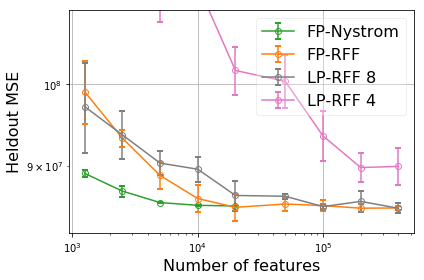

saving  ./figures/census_MSE_vs_n_memory.pdf


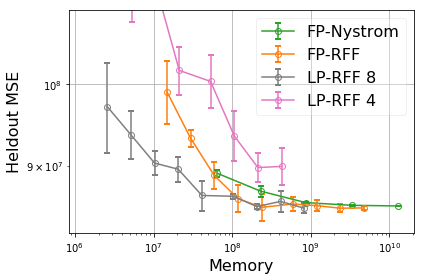

comparing to fp rff best 
 min  85182899.69015567
lp memory saving  2.868217054263566
comparing to cir fp rff best 
 min  85715135.05192329
lp memory saving  15.627906976744185
comparing to nystrom best   min  85428864.49040301
lp memory saving  63.16279069767442


comparing FP RFF to nystrom 20000 
85428864.49040301
branch 1
nystorm  [89097420.13659446 87080557.43432839 85801194.70463473 85496761.98864914
 85428864.49040301] [6.48000e+07 2.29600e+08 8.59200e+08 3.31840e+09 1.30368e+10]
rff  [98988979.63964503 93235390.00230932 88857922.34958045 86247377.72925834
 85274390.54313071 85643422.34786266 85462617.00991666 85182899.69015567
 85208492.14451687] [1.480e+07 2.960e+07 5.920e+07 1.184e+08 2.368e+08 5.920e+08 1.184e+09
 2.368e+09 4.736e+09]
rff index  4 0.0001
memory saving  14.013513513513514


comparing to fp rff best median
median 85643422.34786266
lp memory saving  1.1472868217054264
comparing to cir fp rff best median
median 86850719.50220478
lp memory saving  3.9069767441860

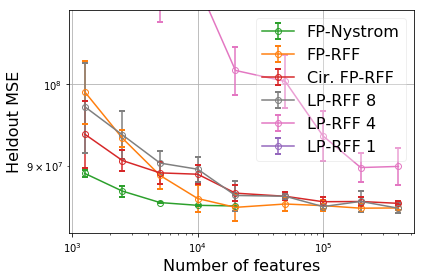

saving  ./figures/census_MSE_vs_n_memory_all_line.pdf


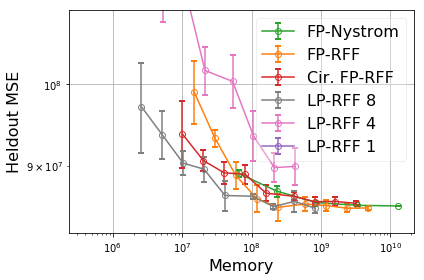

comparing to fp rff best 
 min  85182899.69015567
lp memory saving  2.868217054263566
comparing to cir fp rff best 
 min  85715135.05192329
lp memory saving  15.627906976744185
comparing to nystrom best   min  85428864.49040301
lp memory saving  63.16279069767442


comparing FP RFF to nystrom 20000 
85428864.49040301
branch 1
nystorm  [89097420.13659446 87080557.43432839 85801194.70463473 85496761.98864914
 85428864.49040301] [6.48000e+07 2.29600e+08 8.59200e+08 3.31840e+09 1.30368e+10]
rff  [98988979.63964503 93235390.00230932 88857922.34958045 86247377.72925834
 85274390.54313071 85643422.34786266 85462617.00991666 85182899.69015567
 85208492.14451687] [1.480e+07 2.960e+07 5.920e+07 1.184e+08 2.368e+08 5.920e+08 1.184e+09
 2.368e+09 4.736e+09]
rff index  4 0.0001
memory saving  14.013513513513514


comparing to fp rff best median
median 85643422.34786266
lp memory saving  1.1472868217054264
comparing to cir fp rff best median
median 86850719.50220478
lp memory saving  3.9069767441860

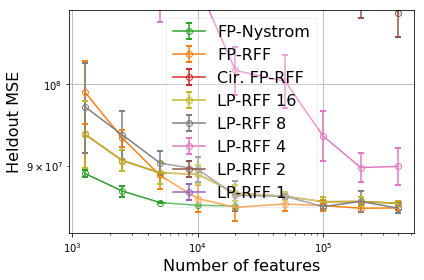

saving  ./figures/census_MSE_vs_n_memory_every_line.pdf


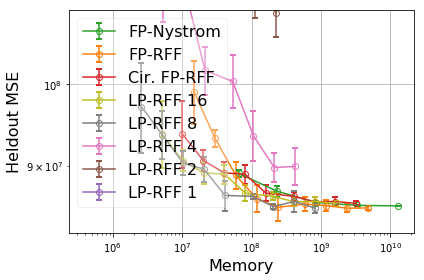

comparing to fp rff best 
 min  85182899.69015567
lp memory saving  2.868217054263566
comparing to cir fp rff best 
 min  85715135.05192329
lp memory saving  15.627906976744185
comparing to nystrom best   min  85428864.49040301
lp memory saving  63.16279069767442


comparing FP RFF to nystrom 20000 
85428864.49040301
branch 1
nystorm  [89097420.13659446 87080557.43432839 85801194.70463473 85496761.98864914
 85428864.49040301] [6.48000e+07 2.29600e+08 8.59200e+08 3.31840e+09 1.30368e+10]
rff  [98988979.63964503 93235390.00230932 88857922.34958045 86247377.72925834
 85274390.54313071 85643422.34786266 85462617.00991666 85182899.69015567
 85208492.14451687] [1.480e+07 2.960e+07 5.920e+07 1.184e+08 2.368e+08 5.920e+08 1.184e+09
 2.368e+09 4.736e+09]
rff index  4 0.0001
memory saving  14.013513513513514


comparing to fp rff best median
median 85643422.34786266
lp memory saving  1.1472868217054264
comparing to cir fp rff best median
median 86850719.50220478
lp memory saving  3.9069767441860

In [20]:
print "census heldout sqrt l2"
m = 250
r = 119
c = 1
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "census_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_0.5_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, 
            do_logy_plot=True, do_logx_plot=True, ylim=[8.25e7, 1.1e8], 
            performance_name="MSE", mem_saving_thresh=mem_saving_thresh)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, 
            do_logy_plot=True, do_logx_plot=True, ylim=[8.25e7, 1.1e8], 
            performance_name="MSE", mem_saving_thresh=mem_saving_thresh, plot_all_line=True)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, 
            do_logy_plot=True, do_logx_plot=True, ylim=[8.25e7, 1.1e8], 
            performance_name="MSE", mem_saving_thresh=mem_saving_thresh, plot_every_line=True)

saving  ./figures/yearpred_MSE_vs_n_feat.pdf


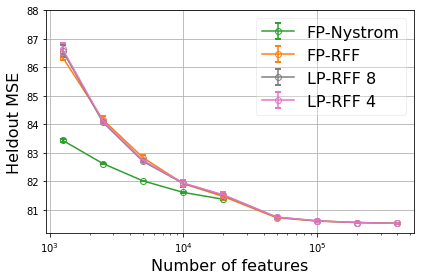

saving  ./figures/yearpred_MSE_vs_n_memory.pdf


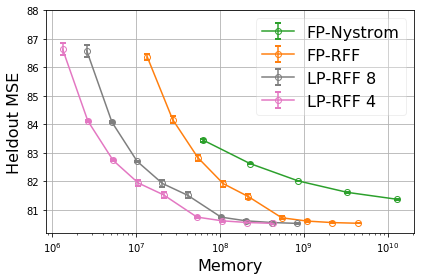

comparing to fp rff best 
 min  80.53403572480472
lp memory saving  10.25563909774436
comparing to cir fp rff best 
 min  80.5291429464301
lp memory saving  7.578947368421052
comparing to nystrom best   min  81.37349299706248
lp memory saving  461.63971631205675


comparing FP RFF to nystrom 20000 
81.37349299706248
branch 1
nystorm  [83.44379904 82.62955138 82.01975115 81.61687232 81.373493  ] [6.364000e+07 2.272800e+08 8.545600e+08 3.309120e+09 1.301824e+10]
rff  [86.3576089  84.17319966 82.8345836  81.9256321  81.468077   80.72597391
 80.61099744 80.55769504 80.53403572] [1.3640e+07 2.7280e+07 5.4560e+07 1.0912e+08 2.1824e+08 5.4560e+08
 1.0912e+09 2.1824e+09 4.3648e+09]
rff index  5 0.0001
memory saving  6.065102639296188


comparing to fp rff best median
median 81.46807700324331
lp memory saving  7.739007092198581
comparing to cir fp rff best median
median 81.51448903082185
lp memory saving  5.719148936170213
comparing to nystrom best median
median 82.01975114764461
lp memory savi

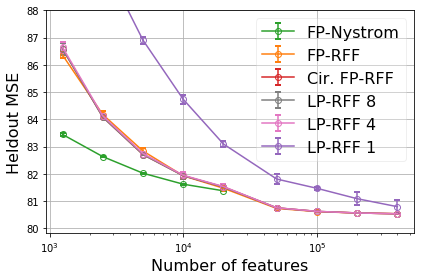

saving  ./figures/yearpred_MSE_vs_n_memory_all_line.pdf


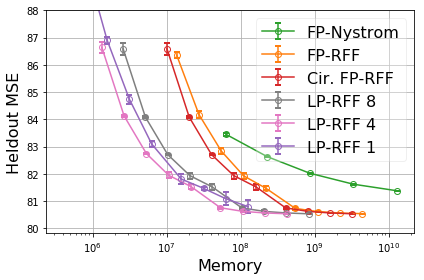

comparing to fp rff best 
 min  80.53403572480472
lp memory saving  10.25563909774436
comparing to cir fp rff best 
 min  80.5291429464301
lp memory saving  7.578947368421052
comparing to nystrom best   min  81.37349299706248
lp memory saving  461.63971631205675


comparing FP RFF to nystrom 20000 
81.37349299706248
branch 1
nystorm  [83.44379904 82.62955138 82.01975115 81.61687232 81.373493  ] [6.364000e+07 2.272800e+08 8.545600e+08 3.309120e+09 1.301824e+10]
rff  [86.3576089  84.17319966 82.8345836  81.9256321  81.468077   80.72597391
 80.61099744 80.55769504 80.53403572] [1.3640e+07 2.7280e+07 5.4560e+07 1.0912e+08 2.1824e+08 5.4560e+08
 1.0912e+09 2.1824e+09 4.3648e+09]
rff index  5 0.0001
memory saving  6.065102639296188


comparing to fp rff best median
median 81.46807700324331
lp memory saving  7.739007092198581
comparing to cir fp rff best median
median 81.51448903082185
lp memory saving  5.719148936170213
comparing to nystrom best median
median 82.01975114764461
lp memory savi

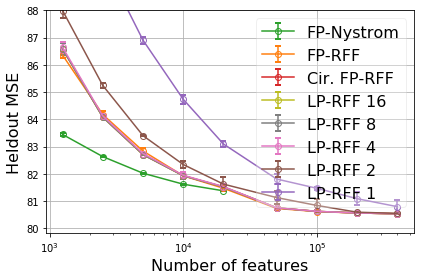

saving  ./figures/yearpred_MSE_vs_n_memory_every_line.pdf


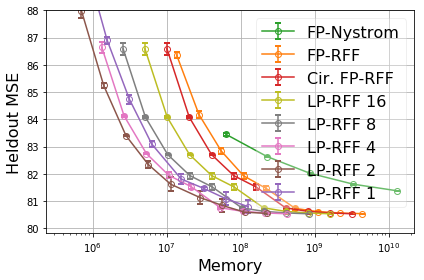

comparing to fp rff best 
 min  80.53403572480472
lp memory saving  10.25563909774436
comparing to cir fp rff best 
 min  80.5291429464301
lp memory saving  7.578947368421052
comparing to nystrom best   min  81.37349299706248
lp memory saving  461.63971631205675


comparing FP RFF to nystrom 20000 
81.37349299706248
branch 1
nystorm  [83.44379904 82.62955138 82.01975115 81.61687232 81.373493  ] [6.364000e+07 2.272800e+08 8.545600e+08 3.309120e+09 1.301824e+10]
rff  [86.3576089  84.17319966 82.8345836  81.9256321  81.468077   80.72597391
 80.61099744 80.55769504 80.53403572] [1.3640e+07 2.7280e+07 5.4560e+07 1.0912e+08 2.1824e+08 5.4560e+08
 1.0912e+09 2.1824e+09 4.3648e+09]
rff index  5 0.0001
memory saving  6.065102639296188


comparing to fp rff best median
median 81.46807700324331
lp memory saving  7.739007092198581
comparing to cir fp rff best median
median 81.51448903082185
lp memory saving  5.719148936170213
comparing to nystrom best median
median 82.01975114764461
lp memory savi

In [21]:
m = 250
r = 90
c = 1
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "yearpred_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_0.5_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, do_logy_plot=False, do_logx_plot=True, 
              performance_name="MSE", ylim=[None, 88.0], mem_saving_thresh=mem_saving_thresh)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, do_logy_plot=False, do_logx_plot=True, 
            performance_name="MSE", ylim=[None, 88.0], mem_saving_thresh=mem_saving_thresh, plot_all_line=True)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, do_logy_plot=False, do_logx_plot=True, 
            performance_name="MSE", ylim=[None, 88.0], mem_saving_thresh=mem_saving_thresh, plot_every_line=True)

covtype heldout accuray
saving  ./figures/covtype_error_vs_n_feat.pdf


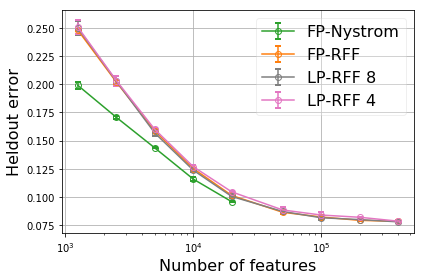

saving  ./figures/covtype_error_vs_n_memory.pdf


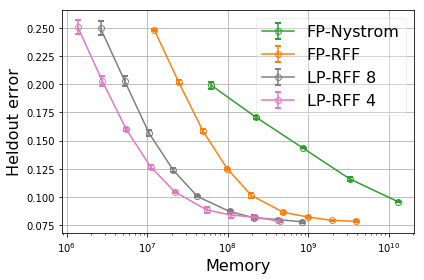

comparing to fp rff best 
 min  0.0783330823347174
lp memory saving  4.67175572519084
comparing to cir fp rff best 
 min  0.07802471260658476
lp memory saving  3.8625954198473282
comparing to nystrom best   min  0.09578107183580387
lp memory saving  237.15036496350365


comparing FP RFF to nystrom 20000 
0.09578107183580387
branch 1
nystorm  [0.19907776 0.17071492 0.14353535 0.11586096 0.09578107] [6.224000e+07 2.244800e+08 8.489600e+08 3.297920e+09 1.299584e+10]
rff  [0.24811572 0.20205389 0.15862395 0.12521962 0.1013389  0.08642241
 0.08222715 0.07926536 0.07833308] [1.2240e+07 2.4480e+07 4.8960e+07 9.7920e+07 1.9584e+08 4.8960e+08
 9.7920e+08 1.9584e+09 3.9168e+09]
rff index  5 0.0001
memory saving  6.735947712418301


comparing to fp rff best median
median 0.10133889833121774
lp memory saving  4.67175572519084
comparing to cir fp rff best median
median 0.10095881471282175
lp memory saving  3.8625954198473282
comparing to nystrom best median
median 0.14353535136220533
lp memory savi

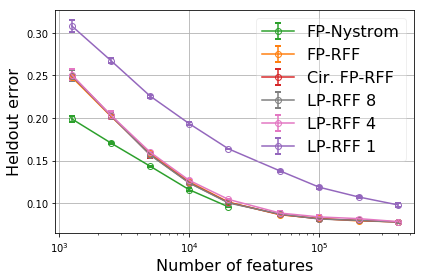

saving  ./figures/covtype_error_vs_n_memory_all_line.pdf


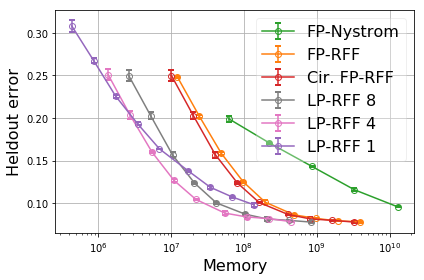

comparing to fp rff best 
 min  0.0783330823347174
lp memory saving  4.67175572519084
comparing to cir fp rff best 
 min  0.07802471260658476
lp memory saving  3.8625954198473282
comparing to nystrom best   min  0.09578107183580387
lp memory saving  237.15036496350365


comparing FP RFF to nystrom 20000 
0.09578107183580387
branch 1
nystorm  [0.19907776 0.17071492 0.14353535 0.11586096 0.09578107] [6.224000e+07 2.244800e+08 8.489600e+08 3.297920e+09 1.299584e+10]
rff  [0.24811572 0.20205389 0.15862395 0.12521962 0.1013389  0.08642241
 0.08222715 0.07926536 0.07833308] [1.2240e+07 2.4480e+07 4.8960e+07 9.7920e+07 1.9584e+08 4.8960e+08
 9.7920e+08 1.9584e+09 3.9168e+09]
rff index  5 0.0001
memory saving  6.735947712418301


comparing to fp rff best median
median 0.10133889833121774
lp memory saving  4.67175572519084
comparing to cir fp rff best median
median 0.10095881471282175
lp memory saving  3.8625954198473282
comparing to nystrom best median
median 0.14353535136220533
lp memory savi

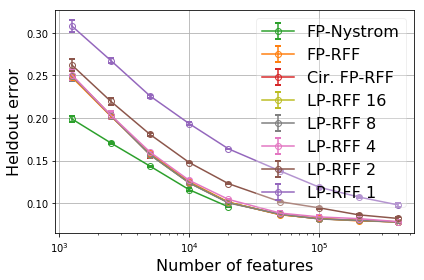

saving  ./figures/covtype_error_vs_n_memory_every_line.pdf


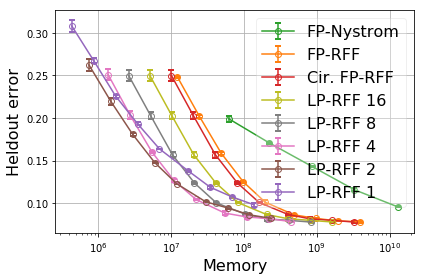

comparing to fp rff best 
 min  0.0783330823347174
lp memory saving  4.67175572519084
comparing to cir fp rff best 
 min  0.07802471260658476
lp memory saving  3.8625954198473282
comparing to nystrom best   min  0.09578107183580387
lp memory saving  237.15036496350365


comparing FP RFF to nystrom 20000 
0.09578107183580387
branch 1
nystorm  [0.19907776 0.17071492 0.14353535 0.11586096 0.09578107] [6.224000e+07 2.244800e+08 8.489600e+08 3.297920e+09 1.299584e+10]
rff  [0.24811572 0.20205389 0.15862395 0.12521962 0.1013389  0.08642241
 0.08222715 0.07926536 0.07833308] [1.2240e+07 2.4480e+07 4.8960e+07 9.7920e+07 1.9584e+08 4.8960e+08
 9.7920e+08 1.9584e+09 3.9168e+09]
rff index  5 0.0001
memory saving  6.735947712418301


comparing to fp rff best median
median 0.10133889833121774
lp memory saving  4.67175572519084
comparing to cir fp rff best median
median 0.10095881471282175
lp memory saving  3.8625954198473282
comparing to nystrom best median
median 0.14353535136220533
lp memory savi

In [22]:
print "covtype heldout accuray"
m = 250
r = 54
c = 2
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "covtype_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_50.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, ylim=[None, None], performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, ylim=[None, None], performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True, plot_all_line=True)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, ylim=[None, None], performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True, plot_every_line=True)

In [10]:
# print "covtype heldout cross entropy"
# m = 250
# r = 54
# c = 2
# rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
# nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
# cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
# general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
# general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
# subfolder_pattern = "covtype_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_50.0_seed_unk"
# nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
# rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
# plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
#             rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
#             cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, performance_file_name="monitor_signal.txt",
#             do_logy_plot=False, do_logx_plot=True, performance_name="cross_entropy", mem_saving_thresh=mem_saving_thresh)

timit heldout accuracy
saving  ./figures/timit_error_vs_n_feat.pdf


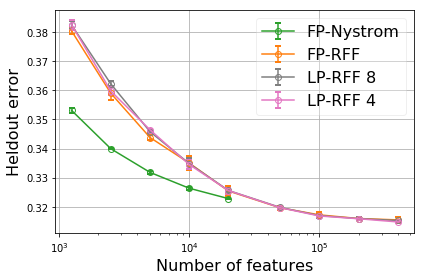

saving  ./figures/timit_error_vs_n_memory.pdf


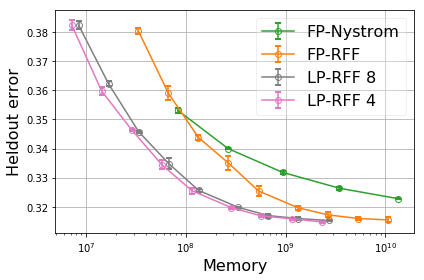

comparing to fp rff best 
 min  0.31548320695895243
lp memory saving  5.115355233002292
comparing to cir fp rff best 
 min  0.3153880352896549
lp memory saving  2.4323911382734913
comparing to nystrom best   min  0.32279646994682626
lp memory saving  50.93842627960275


comparing FP RFF to nystrom 20000 
0.32279646994682626
branch 1
nystorm  [0.35308961 0.33994233 0.33181331 0.32636405 0.32279647] [8.348000e+07 2.669600e+08 9.339200e+08 3.467840e+09 1.333568e+10]
rff  [0.38039029 0.35899433 0.3437995  0.33501515 0.32541913 0.31963677
 0.31720853 0.31595499 0.31548321] [3.34800e+07 6.69600e+07 1.33920e+08 2.67840e+08 5.35680e+08 1.33920e+09
 2.67840e+09 5.35680e+09 1.07136e+10]
rff index  5 0.0001
memory saving  2.5894862604540023


comparing to fp rff best median
median 0.32541912923360977
lp memory saving  2.046142093200917
comparing to cir fp rff best median
median 0.32584060376907004
lp memory saving  2.2203626220362622
comparing to nystrom best median
median 0.33181330581512497
lp 

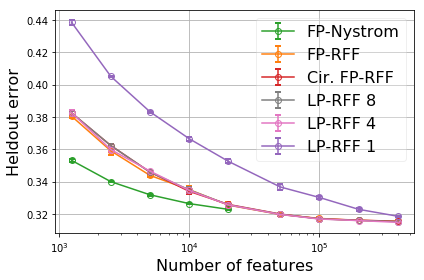

saving  ./figures/timit_error_vs_n_memory_all_line.pdf


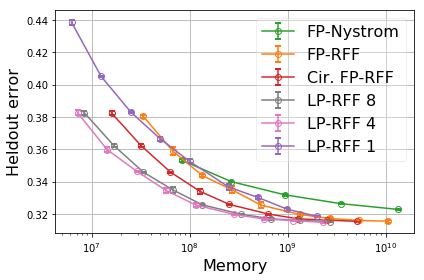

comparing to fp rff best 
 min  0.31548320695895243
lp memory saving  5.115355233002292
comparing to cir fp rff best 
 min  0.3153880352896549
lp memory saving  2.4323911382734913
comparing to nystrom best   min  0.32279646994682626
lp memory saving  50.93842627960275


comparing FP RFF to nystrom 20000 
0.32279646994682626
branch 1
nystorm  [0.35308961 0.33994233 0.33181331 0.32636405 0.32279647] [8.348000e+07 2.669600e+08 9.339200e+08 3.467840e+09 1.333568e+10]
rff  [0.38039029 0.35899433 0.3437995  0.33501515 0.32541913 0.31963677
 0.31720853 0.31595499 0.31548321] [3.34800e+07 6.69600e+07 1.33920e+08 2.67840e+08 5.35680e+08 1.33920e+09
 2.67840e+09 5.35680e+09 1.07136e+10]
rff index  5 0.0001
memory saving  2.5894862604540023


comparing to fp rff best median
median 0.32541912923360977
lp memory saving  2.046142093200917
comparing to cir fp rff best median
median 0.32584060376907004
lp memory saving  2.2203626220362622
comparing to nystrom best median
median 0.33181330581512497
lp 

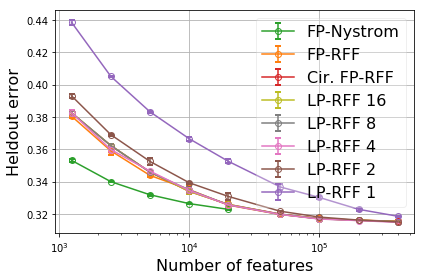

saving  ./figures/timit_error_vs_n_memory_every_line.pdf


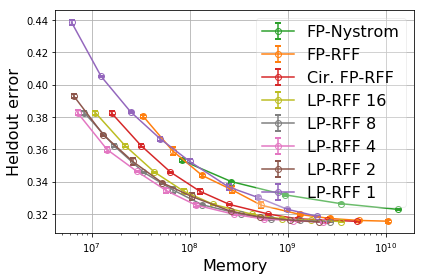

comparing to fp rff best 
 min  0.31548320695895243
lp memory saving  5.115355233002292
comparing to cir fp rff best 
 min  0.3153880352896549
lp memory saving  2.4323911382734913
comparing to nystrom best   min  0.32279646994682626
lp memory saving  50.93842627960275


comparing FP RFF to nystrom 20000 
0.32279646994682626
branch 1
nystorm  [0.35308961 0.33994233 0.33181331 0.32636405 0.32279647] [8.348000e+07 2.669600e+08 9.339200e+08 3.467840e+09 1.333568e+10]
rff  [0.38039029 0.35899433 0.3437995  0.33501515 0.32541913 0.31963677
 0.31720853 0.31595499 0.31548321] [3.34800e+07 6.69600e+07 1.33920e+08 2.67840e+08 5.35680e+08 1.33920e+09
 2.67840e+09 5.35680e+09 1.07136e+10]
rff index  5 0.0001
memory saving  2.5894862604540023


comparing to fp rff best median
median 0.32541912923360977
lp memory saving  2.046142093200917
comparing to cir fp rff best median
median 0.32584060376907004
lp memory saving  2.2203626220362622
comparing to nystrom best median
median 0.33181330581512497
lp 

In [23]:
print "timit heldout accuracy"
m = 250
r = 440
c = 147
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "timit_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_100.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True, plot_all_line=True)
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True, plot_every_line=True)

In [12]:
# print "timit heldout cross entropy"
# m = 250
# r = 440
# c = 147
# rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
# nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
# cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
# general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
# general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
# subfolder_pattern = "timit_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_100.0_seed_unk"
# nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
# rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
# plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
#             rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func,
#             cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, performance_file_name="monitor_signal.txt",
#             do_logy_plot=False, do_logx_plot=True, performance_name="cross_entropy", mem_saving_thresh=mem_saving_thresh)

timit heldout accuracy
halp 8 8  (array([0.39861974, 0.36974601, 0.34988233, 0.33560658, 0.327449  ,
       0.32016021, 0.31703179, 0.3167993 , 0.31525751]),)
halp 4 4  (array([0.414527  , 0.40059387, 0.39918669, 0.38746426, 0.40473792,
       0.40769096, 0.39624589, 0.38581643, 0.37685942]),)
halp 8 4  (array([0.38394427, 0.37777714, 0.35232144, 0.33524356, 0.3261234 ,
       0.32165713, 0.31822279, 0.31621603, 0.31526567]),)
basic 4 4  [array([0.38157857, 0.3593859 , 0.34598709, 0.3339669 , 0.32688613,
       0.31984615, 0.31648115, 0.31546145, 0.31518002])]
perf ratio  [1.00619976 1.05117409 1.01830807 1.00382271 0.99766667 1.00566204
 1.00550314 1.00239197 1.00027176]
perf ratio 2  [0.99617462 0.97129123 0.99031463 0.99808319 1.00113314 0.9973374
 0.99745195 0.99889769 0.99987492]
 4 bit mem ref  [7.1700e+06 1.4340e+07 2.8680e+07 5.7360e+07 1.1472e+08 2.8680e+08
 5.7360e+08 1.1472e+09 2.2944e+09]
mem ref  [8.4200e+06 1.6840e+07 3.3680e+07 6.7360e+07 1.3472e+08 3.3680e+08
 6.7360e+0

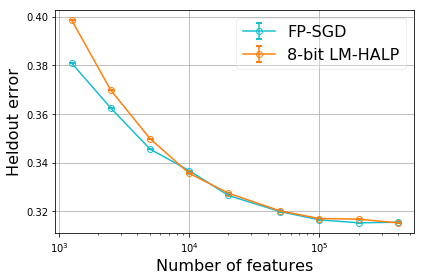

In [13]:
print "timit heldout accuracy"
m = 250
r = 440
c = 147
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "timit_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_100.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, performance_name="error", 
            mem_saving_thresh=mem_saving_thresh, y_reverse=True, plot_halp=True)